# Estimación de ubicación, variabilidad y sesgo


In [50]:
import pandas as pd

Base de datos de objetos de interés del observatorio de exoplanetas Kepler

In [51]:
# Load the exoplanet database
data_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepid,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr&format=csv"
df_kepler = pd.read_csv(data_url)

In [52]:
#Dimensiones del dataframe
df_kepler.shape

(9564, 11)

In [53]:
#cantidad de datos NA
nans_per_column=df_kepler.isna().sum(axis=0)
nans_per_column

,0
kepid,0
kepoi_name,0
koi_disposition,0
koi_period,0
koi_impact,363
koi_duration,0
koi_depth,363
koi_prad,363
koi_teq,363
koi_insol,321


Limpieza

In [54]:
df_kepler_clean=df_kepler.dropna().reset_index(drop=True)
df_kepler_clean

,kepid,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr
0,10797460,K00752.01,CONFIRMED,9.488036,0.146,2.95750,615.8,2.26,793.0,93.59,35.8
1,10797460,K00752.02,CONFIRMED,54.418383,0.586,4.50700,874.8,2.83,443.0,9.11,25.8
2,10811496,K00753.01,CANDIDATE,19.899140,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3
3,10848459,K00754.01,FALSE POSITIVE,1.736952,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6
4,10854555,K00755.01,CONFIRMED,2.525592,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9
...,...,...,...,...,...,...,...,...,...,...,...
9196,10090151,K07985.01,FALSE POSITIVE,0.527699,1.252,3.22210,1579.2,29.35,2088.0,4500.53,453.3
9197,10128825,K07986.01,CANDIDATE,1.739849,0.043,3.11400,48.5,0.72,1608.0,1585.81,10.6
9198,10147276,K07987.01,FALSE POSITIVE,0.681402,0.147,0.86500,103.6,1.07,2218.0,5713.41,12.3
9199,10155286,K07988.01,CANDIDATE,333.486169,0.214,3.19900,639.1,19.30,557.0,22.68,14.0


Estimación de la ubicación, variabilidad y sesgo del radio planetario

In [55]:
planet_radius=df_kepler_clean['koi_prad']
print(f'La media del radio es {planet_radius.mean()}, y la mediana es {planet_radius.median()}' )

La media del radio es 102.89177806760135, y la mediana es 2.39


Este resultado muestra una gran disparidad entre la media y la mediana, lo que sugiere la presencia de valores atípicos en las colas. Un estimador más robusto para el centro de la distribución es la media recortada.

In [56]:
from scipy.stats import trim_mean

In [57]:
print(f'La media truncada al 20% es:{trim_mean(planet_radius,0.2)}')

La media truncada al 20% es:4.664966491577612


Estimaciones de variabilidad

In [58]:
print(f'La desviación estandar es {planet_radius.std()}')

La desviación estandar es 3077.639126222184


In [59]:
print(f'El radio maximo es {planet_radius.max()}, y el minimo es {planet_radius.min()}')

El radio maximo es 200346.0, y el minimo es 0.08


Estimaciones basadas en percentiles

In [60]:
print(f'El primer cuartil se ubica en {planet_radius.quantile(0.25)}, y el tercer cuartil en {planet_radius.quantile(0.75)}')

El primer cuartil se ubica en 1.4, y el tercer cuartil en 14.93


Rango intercuartil

In [61]:
iqr=planet_radius.quantile(0.75)-planet_radius.quantile(0.25)
print(f'Rango intercuartil: {iqr}')

Rango intercuartil: 13.53


Curtosis y grado de asimetría (Skewness)

In [62]:
print(f'Asimetría de los radios planetarios {planet_radius.skew()}, y su curtosis relativa {planet_radius.kurtosis()}')

Asimetría de los radios planetarios 52.11895420603228, y su curtosis relativa 2974.9107107967575


## Filtrado
Se deben cortar los valores en los extremos de la distribución para reducir la disparidad entre la media y la mediana

In [63]:
def filter(df,col,iqr_score):
  iqr_col=df[col].quantile(0.75)-df[col].quantile(0.25)
  filter_lower=df[col]>df[col].quantile(0.25)-(iqr_col*iqr_score)
  filter_upper=df[col]<df[col].quantile(0.75)+(iqr_col*iqr_score)
  return df[filter_lower & filter_upper]

In [64]:
df_filtered=df_kepler_clean.copy()
df_filtered=filter(df_kepler_clean,'koi_prad',2)

Estimaciones estadisticas sobre los datos filtrados

In [65]:
planet_radius_fil=df_filtered['koi_prad']

In [66]:
print(f'Media: {planet_radius_fil.mean()}, Mediana: {planet_radius_fil.median()}' )

Media: 5.983313668884147, Mediana: 2.08


In [67]:
print(f'Media truncada al 20% :{trim_mean(planet_radius_fil,0.2)}')

Media truncada al 20% :2.3407948128006693


In [68]:
print(f'Desviación estandar: {planet_radius_fil.std()}')

Desviación estandar: 9.33957049425806


In [69]:
print(f'Maximo: {planet_radius_fil.max()}, y minimo: {planet_radius_fil.min()}')

Maximo: 41.84, y minimo: 0.08


In [70]:
print(f'El primer cuartil se ubica en {planet_radius_fil.quantile(0.25)}, y el tercer cuartil se ubica en {planet_radius_fil.quantile(0.75)}')

El primer cuartil se ubica en 1.31, y el tercer cuartil se ubica en 3.9450000000000003


In [71]:
iqr_fil=planet_radius_fil.quantile(0.75)-planet_radius_fil.quantile(0.25)
print(f'Rango intercuartil {iqr_fil}')

Rango intercuartil 2.6350000000000002


In [72]:
print(f'Asimetría(skewness): {planet_radius_fil.skew()}, Curtosis relativa: {planet_radius_fil.kurtosis()}')

Asimetría(skewness): 2.2853973411240904, Curtosis relativa: 4.165212647859917


## Visualización de Datos
Grafico de caja


In [74]:
import seaborn as sns

[Text(0.5, 0, 'Radio planetario (Radios terrestres)')]

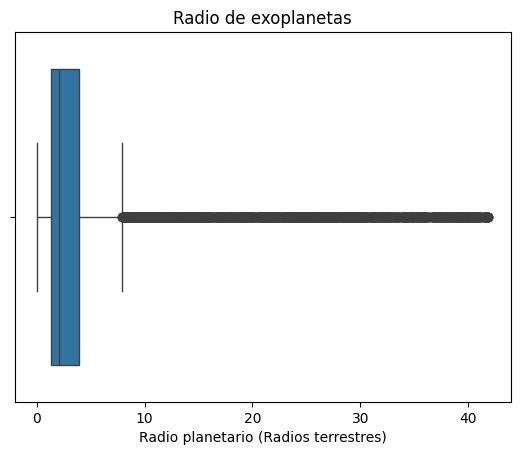

In [76]:
ax0=sns.boxplot(x=df_filtered['koi_prad'])
ax0.set_title ('Radio de exoplanetas')
ax0.set(xlabel='Radio planetario (Radios terrestres)')

Tabla de frecuencias


In [78]:
import numpy as np

In [80]:
bins_radius=int(1+np.log2(planet_radius_fil.size))
print(f"De acuerdo a la regla de Sturges, el numero optimo de intervalos para los radios es {bins_radius}")

De acuerdo a la regla de Sturges, el numero optimo de intervalos para los radios es 13


In [84]:
frequencies_radius=pd.cut(planet_radius_fil,bins_radius)
frequencies_radius

,koi_prad
0,"(0.0382, 3.292]"
1,"(0.0382, 3.292]"
2,"(12.929, 16.142]"
3,"(32.203, 35.415]"
4,"(0.0382, 3.292]"
...,...
9196,"(28.991, 32.203]"
9197,"(0.0382, 3.292]"
9198,"(0.0382, 3.292]"
9199,"(16.142, 19.354]"


In [85]:
planet_radius_fil.groupby(frequencies_radius).count()

<ipython-input-85-8aafb2bcbe5a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  planet_radius_fil.groupby(frequencies_radius).count()


,koi_prad
koi_prad,
"(0.0382, 3.292]",5691
"(3.292, 6.505]",693
"(6.505, 9.717]",237
"(9.717, 12.929]",181
"(12.929, 16.142]",148
"(16.142, 19.354]",122
"(19.354, 22.566]",135
"(22.566, 25.778]",153
"(25.778, 28.991]",141


### Histograma

[Text(0, 0.5, 'Cantidad')]

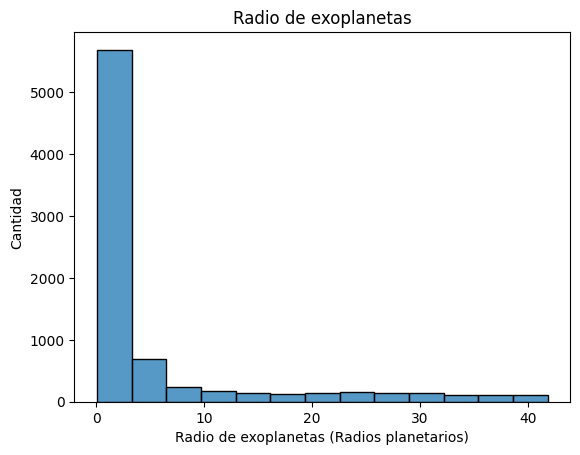

In [88]:
ax1=sns.histplot(planet_radius_fil,bins=bins_radius)
ax1.set_title ('Radio de exoplanetas')
ax1.set(xlabel='Radio de exoplanetas (Radios terrestres)')
ax1.set(ylabel='Cantidad')

### Estimación de Kernel de densidad

[Text(0, 0.5, 'Densidad de probabilidad')]

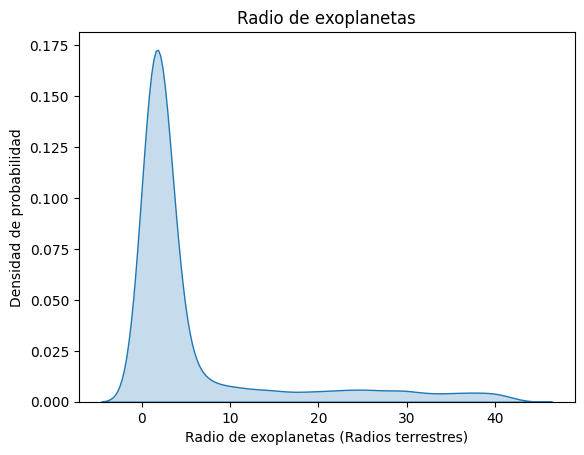

In [89]:
ax2=sns.kdeplot(planet_radius_fil,fill=True)
ax2.set_title ('Radio de exoplanetas')
ax2.set(xlabel='Radio de exoplanetas (Radios terrestres)')
ax2.set(ylabel='Densidad de probabilidad')